In [1]:
import numpy as np
from torchvision import transforms
from PIL import Image
import tritonclient.http as httpclient
from tritonclient.utils import triton_to_np_dtype

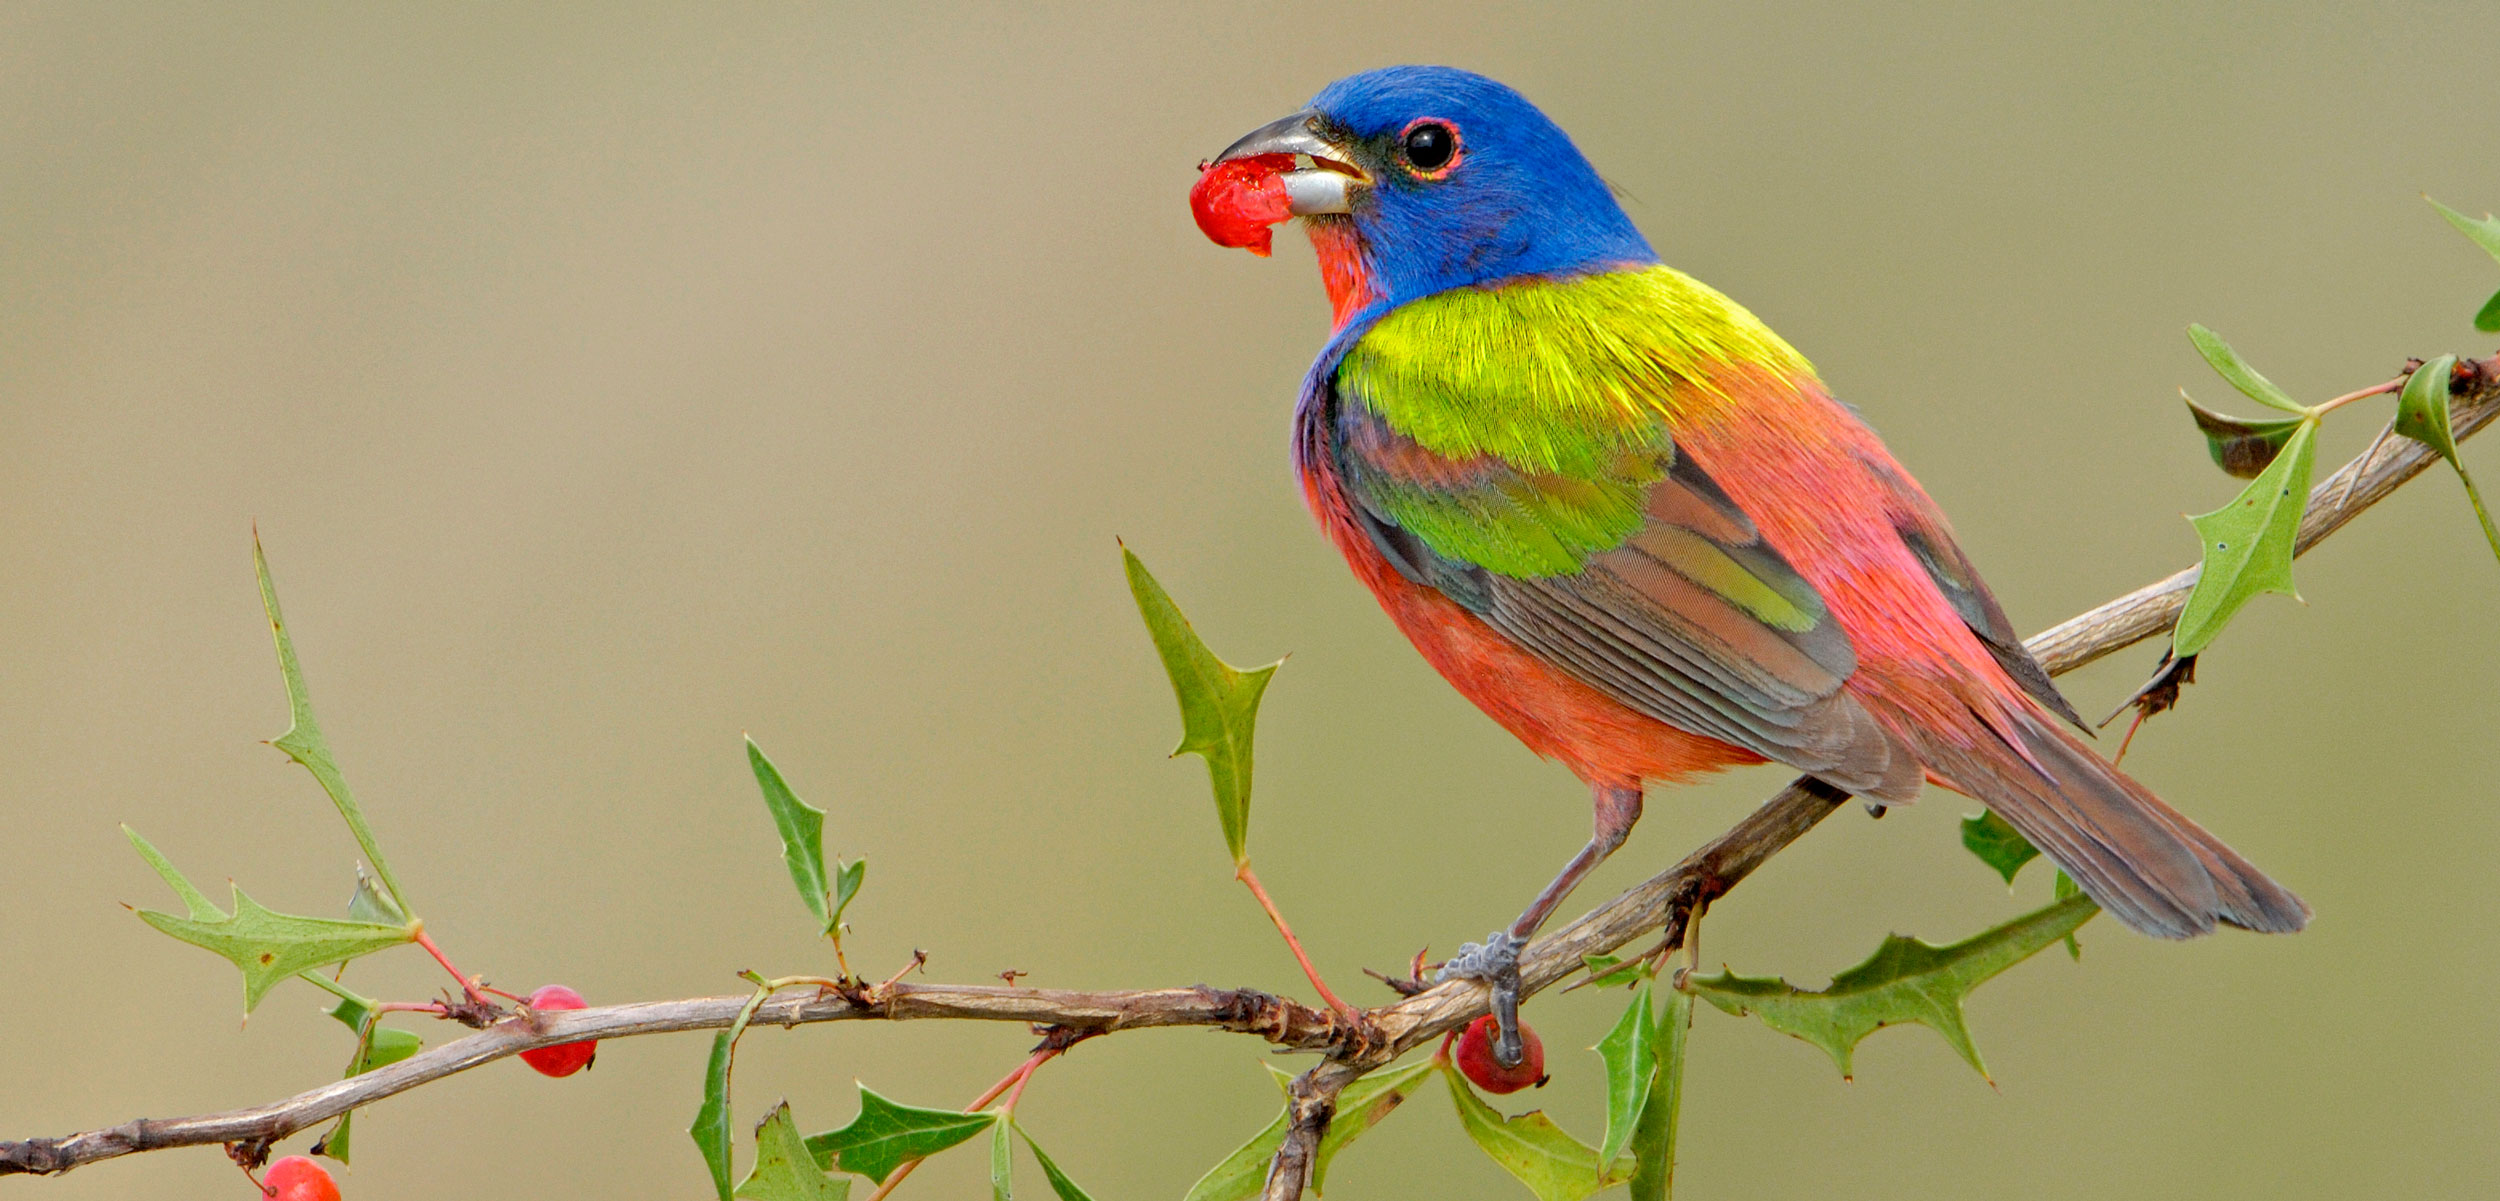

[[92.       11.548581]
 [14.       11.231399]
 [95.        7.527269]
 [17.        6.922706]
 [88.        6.57627 ]]


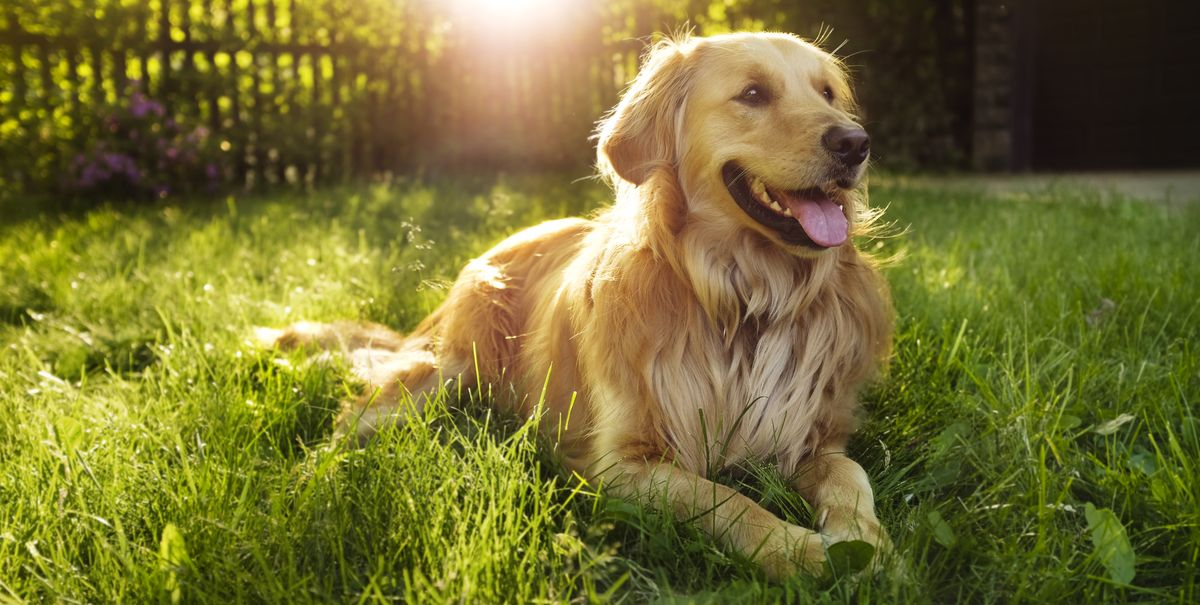

[[207.        11.356841]
 [212.         9.102118]
 [222.         8.791483]
 [208.         8.410839]
 [852.         7.991486]]


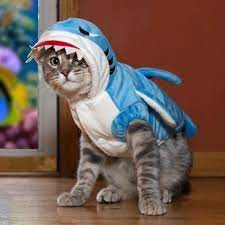

[[285.         9.262123]
 [292.         9.046752]
 [281.         8.124939]
 [282.         7.72466 ]
 [917.         7.227952]]


In [13]:
# preprocessing function
def rn50_preprocess(img_path):
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return np.expand_dims(preprocess(img).numpy(),axis=0)

def plt_img(img_path):
    from IPython.display import display
    pil_im = Image.open(img_path)
    display(pil_im)

img_list = ["img1.jpg","img2.jpg", "img3.jpg"]
for img in img_list:
    plt_img(img)
    transformed_img = rn50_preprocess(img)

    # Setting up client
    client = httpclient.InferenceServerClient(url="localhost:8000")

    inputs = httpclient.InferInput("data_0", transformed_img.shape, datatype="FP32")
    inputs.set_data_from_numpy(transformed_img, binary_data=True)

    outputs = httpclient.InferRequestedOutput("fc6_1", binary_data=True, class_count=1000)

    # Querying the server
    results = client.infer(model_name="densenet_onnx", inputs=[inputs], outputs=[outputs])
    inference_output = results.as_numpy('fc6_1').astype(str)
    
    np_results = np.squeeze(inference_output)[:5]
    print(np.array([tuple(map(float, item.split(':')[::-1])) for item in np_results]))